In [1]:
# autoreload
%load_ext autoreload
%autoreload 2

# configure logging
import logging
logging.basicConfig(level=logging.WARNING)
logging.getLogger('Assignment1MicroarrayEpigeneticClock').setLevel(logging.DEBUG)
logging.getLogger('GlmNetEpigeneticClockTrainer').setLevel(logging.DEBUG)
logging.getLogger('download_file').setLevel(logging.DEBUG)

In [2]:
%%time
import os
from epigenetic_clock_assignment import download_file, download_nextcloud_file

data_dir = 'data/assignment1'
meta_filepath = os.path.join(data_dir, 'GSE40279_family.soft-MetaData.csv')
features_filepath = os.path.join(data_dir, 'GSE40279_average_beta.txt')
features_gz_filepath = os.path.join(data_dir, 'GSE40279_average_beta.txt.gz')

# download meta file if does not exists
download_nextcloud_file(folder_url='https://nc.elte.hu/s/9E36fFCnWML33yN',
                       filename='GSE40279_family.soft-MetaData.csv',
                       out_filepath=meta_filepath,
                       password='GSE40279')

# download features file if does not exists
download_file(url='https://www.ncbi.nlm.nih.gov/geo/download/?acc=GSE40279&format=file&file=GSE40279%5Faverage%5Fbeta%2Etxt%2Egz',
              out_filepath=features_filepath,
              intermediate_archive_filepath=features_gz_filepath,
              archive_format='gzip')


DEBUG:download_file:file data/assignment1/GSE40279_average_beta.txt already exists; do not download again


CPU times: user 1.61 s, sys: 4.09 s, total: 5.7 s
Wall time: 732 ms


In [3]:
%%time

import os
from epigenetic_clock_assignment import Assignment1MicroarrayDataSource

data_source = Assignment1MicroarrayDataSource(
        meta_filepath=meta_filepath,
        features_filepath=features_filepath
)

X, y = data_source.load()


CPU times: user 13.3 s, sys: 1.05 s, total: 14.3 s
Wall time: 14.3 s


In [26]:
%%time
from epigenetic_clock_assignment import GlmNetEpigeneticClockTrainer

clock_trainer = GlmNetEpigeneticClockTrainer(
    n_parallel_jobs=2,
    n_cv_fold=3,
    # the weight of standard error used to determine lambda_best, 0 means use lambda_max (see glmnet.ElasticNet)
    std_error_weight_for_lambda_best=0.5,
    seed=42
)

X_train, X_test, y_train, y_test = clock_trainer.train_test_split(X, y, 
                                                                  test_size=0.2)

hyperparameter_result, hyperparameter_stats, best_model = clock_trainer.hyperparameter_optimization(
    X_train=X_train, 
    y_train=y_train, 
    alpha_count=2 + 1)


DEBUG:GlmNetEpigeneticClockTrainer:starting hyperparameter optimization with alpha range [0.  0.5 1. ]
DEBUG:GlmNetEpigeneticClockTrainer:training with alpha 0.0...
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   3 out of   3 | elapsed:   16.7s finished
DEBUG:GlmNetEpigeneticClockTrainer:training with alpha 0.5...


lambda_max 32 633.7470006985235
target_score 0.7340968686027308 0.5 0.04817365805851659 = 0.7100100395734725
self.lambda_best_ [633.7470007]


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   3 out of   3 | elapsed:   13.0s finished
DEBUG:GlmNetEpigeneticClockTrainer:training with alpha 1.0...


lambda_max 37 0.7960231729550125
target_score 0.8810246318521392 0.5 0.0208696346443962 = 0.8705898145299411
self.lambda_best_ [0.87363445]


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.


lambda_max 35 0.4794063649761707
target_score 0.878817612015471 0.5 0.020543857830698054 = 0.868545683100122
self.lambda_best_ [0.47940636]
STATS           lambda  alpha  cv_r2_mean  cv_r2_std  model_index
0   12440.711242    0.0    0.204970   0.207524            0
1   11335.512743    0.0    0.512513   0.057642            0
2   10328.497033    0.0    0.676166   0.030495            0
3    9410.941823    0.0    0.679888   0.031493            0
4    8574.899689    0.0    0.684258   0.031190            0
..           ...    ...         ...        ...          ...
55      0.074580    1.0    0.872709   0.023073            2
56      0.067955    1.0    0.872621   0.023046            2
57      0.061918    1.0    0.872584   0.023028            2
58      0.056417    1.0    0.872584   0.023028            2
59      0.051405    1.0    0.872584   0.023028            2

[154 rows x 5 columns]
CPU times: user 1min 43s, sys: 30.8 s, total: 2min 14s
Wall time: 1min 9s


[Parallel(n_jobs=2)]: Done   3 out of   3 | elapsed:   13.1s finished


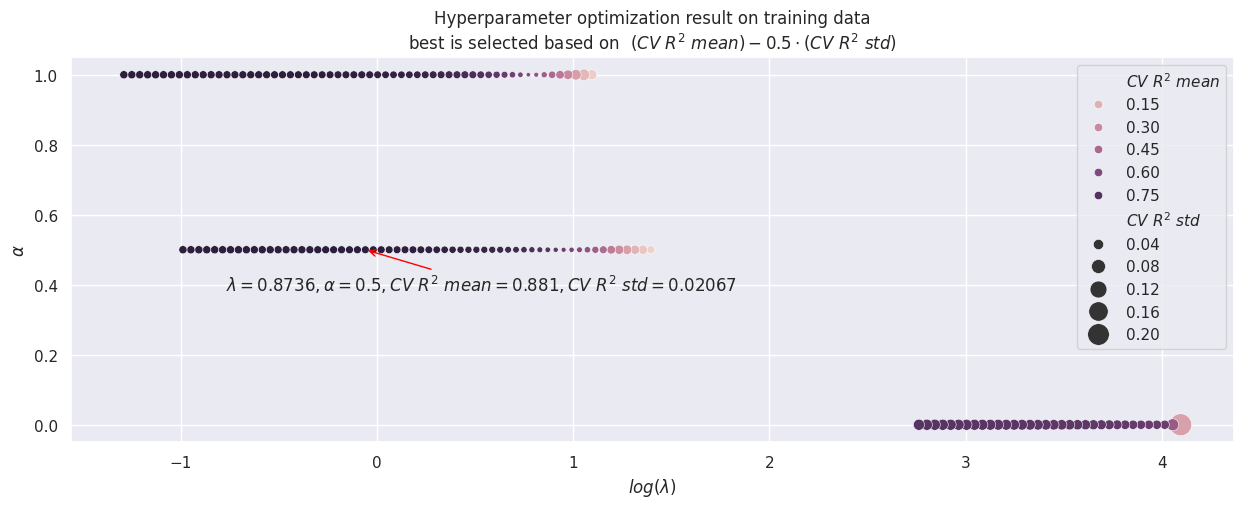

2

In [27]:
clock_trainer.plot_hyperparameter_optimization_result(hyperparameter_result=hyperparameter_result, hyperparameter_stats=hyperparameter_stats, arrow_xytext_offset=(-100, -30))
hyperparameter_stats
hyperparameter_stats.dtypes
a = [1,2,3]
int(hyperparameter_stats.iloc[-1]['model_index'])

# Predict on test data using the best model

In [29]:
best_lambda = hyperparameter_result.lambd
best_alpha = hyperparameter_result.alpha

# sanity check
assert best_model.alpha == best_alpha
assert best_model.lambda_best_ == best_lambda

# predict
y_pred = best_model.predict(X = X_test, lamb=best_lambda)


# Plot linear regression result

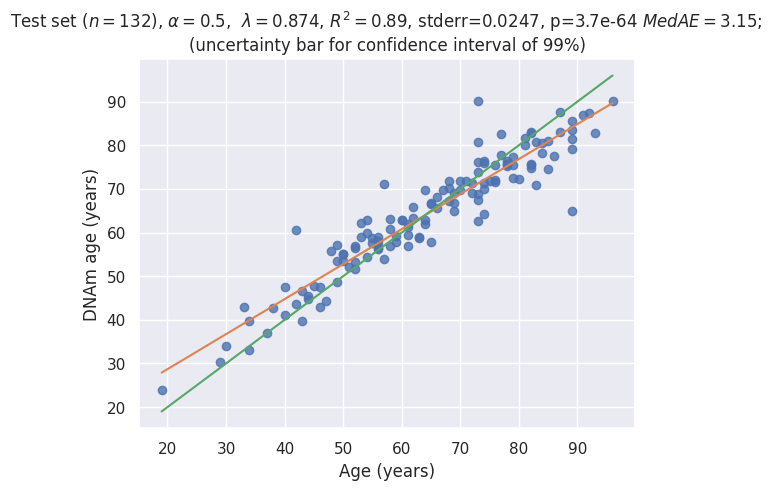

Statistics(r2=0.8899575122514448, slope=0.8023869322262798, intercept=12.645500329493622, p_value=3.7193640335718896e-64, standard_error=0.024746155308912568, medae=3.147566221066903)
[[66.         68.19845373]
 [51.         52.01535066]]


In [39]:
stats = clock_trainer.calculate_statistics(y_true=y_test, y_pred=y_pred)
clock_trainer.plot_linear_regression_result(y_true=y_test, y_pred=y_pred, stats=stats, alpha=best_alpha, lamb=best_lambda)

print(stats)

import numpy as np
print(np.column_stack((y_test[:2], y_pred[:2])))

In [8]:
# P


import numpy as np




model=best_model
print('n_lambda_', model.n_lambda_)
print('lambda_path_', model.lambda_path_, model.lambda_path_.shape)
print('coef_path_', model.coef_path_, model.coef_path_.shape)
print('coef_ for lambda_best', model.coef_, model.coef_.dtype, model.coef_.shape)
print('coef_ nonzero', np.count_nonzero(np.invert(np.isclose(model.coef_, 0, atol=np.finfo(model.coef_.dtype).tiny, rtol=0))))
print('intercept_ for lambda_best', model.intercept_)
print('intercept_path', model.intercept_path_, model.intercept_path_.shape)
print('cv_mean_score_', model.cv_mean_score_, model.cv_mean_score_.shape)
print('cv_standard_error_', model.cv_standard_error_)
print('lambda_max_', model.lambda_max_)
print('lambda_best_', model.lambda_best_)

n_lambda_ 60
lambda_path_ [124.40711242 113.35512743 103.28497033  94.10941823  85.74899689
  78.13129234  71.19032367  64.86597153  59.10345739  53.85286913
  49.06872866  44.70959805  40.73772058  37.11869376  33.82117131
  30.81659167  28.0789306   25.58447579  23.31162148  21.24068128
  19.35371769  17.63438675  16.06779644  14.64037769  13.33976688
  12.15469876  11.07490882  10.09104445   9.19458387   8.37776238
   7.63350506   6.95536551   6.33747001   5.77446664   5.26147894
   4.79406365   4.36817225   3.98011586   3.62653334   3.30436211
   3.01081169   2.74333948   2.49962876   2.27756863   2.07523571
   1.89087749   1.72289714   1.56983971   1.43037948   1.30330851
   1.18752617   1.08202962   0.98590509   0.89832      0.81851573
   0.74580105   0.67954614   0.61917713   0.56417114   0.51405173] (60,)
coef_path_ [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]] (473034,

In [9]:
# TODO: 

# Feature importance based
# Shap Feature Importance
# feature matrix
# glider-nel mint tanitottunk es min teszteltunk
# scatter plot, ahol sok pont van, ott pirosabb (hoterkep)


# delta age  pred - pred age
# delta age az colleral az eletkorral (fiatalokra gyakran lesz pozitiv , oregekre negativ)
# age acc. : prefictalt eletkorbol kivonjuk a regresszios egyenest -> az az erdekes, akik kilognak